In [1]:
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
from sklearn.impute import SimpleImputer

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# --- Configuration ---
FILE_PATH = "/content/drive/My Drive/Big Data Project/Data/Processed/asthma_data_with_engineered_pollutants.csv"
N_NEIGHBORS = 4  # How many nearest counties to connect for the graph
N_YEARS = 4      # Number of years in the dataset (2020-2023)
TRAIN_YEARS = 3  # Use first 3 years for training
TEST_YEARS = 1   # Use last 1 year for testing
HIDDEN_DIM = 32  # Number of hidden units in GNN/RNN
EPOCHS = 500     # Number of training epochs
LEARNING_RATE = 0.005

# --- 1. Data Loading and Preprocessing ---
print("--- 1. Loading and Preprocessing Data ---")
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Original shape: {df.shape}")

    # --- Filter out rows with blank State Name ---
    if 'State Name' in df.columns:
        shape_before_filter = df.shape[0]
        df.dropna(subset=['State Name'], inplace=True)
        df = df[df['State Name'].astype(str).str.strip() != ''].copy()
        print(f"Shape after filtering non-blank State Name: {df.shape} ({shape_before_filter - df.shape[0]} rows removed)")
    else:
        print("Warning: 'State Name' column not found. Cannot filter.")

    # --- Handling missing Lat/Lon by dropping rows ---
    lat_col = 'Eng_Latitude'
    lon_col = 'Eng_Longitude'

    if lat_col not in df.columns or lon_col not in df.columns:
        print(f"Warning: '{lat_col}' or '{lon_col}' not found. Trying 'Latitude', 'Longitude'.")
        lat_col = 'Latitude'
        lon_col = 'Longitude'
        if lat_col not in df.columns or lon_col not in df.columns:
            print("ERROR: Could not find suitable Latitude/Longitude columns. Check your CSV file.")
            raise ValueError("Missing Lat/Lon columns")

    print(f"Shape before dropping NA Lat/Lon: {df.shape}")
    df.dropna(subset=[lat_col, lon_col], inplace=True)
    print(f"Shape after dropping NA Lat/Lon: {df.shape}")

    # Ensure data is sorted for consistent county mapping and temporal order
    df.sort_values(by=['County Name', 'Year'], inplace=True)

    # Create a mapping from county name to integer ID (using the filtered data)
    counties = df['County Name'].unique()
    county_to_id = {name: i for i, name in enumerate(counties)}
    df['CountyID'] = df['County Name'].map(county_to_id)
    n_counties = len(counties)

    # --- Define features dynamically starting from 'PM25_Annual_Mean' ---
    start_col_name = 'PM25_Annual_Mean'
    all_cols = df.columns.tolist()

    try:
        start_index = all_cols.index(start_col_name)
        potential_features = all_cols[start_index:]

        # Define columns to EXCLUDE from features
        exclude_cols = [
            'CountyID', 'Hotspot', 'Age-adjusted rate per 10,000',
            'Number of cases', 'Year',
            'County Name', 'State Name', 'Latitude', 'Longitude',
            'Eng_Latitude', 'Eng_Longitude'
            ]

        features_cols = [col for col in potential_features if col not in exclude_cols]
        print(f"Identified {len(features_cols)} features starting from '{start_col_name}'.")

    except ValueError:
        print(f"ERROR: Start column '{start_col_name}' not found in DataFrame.")
        features_cols = []

    target_col = 'Age-adjusted rate per 10,000'

    # Check if target column exists
    if target_col not in df.columns:
         raise ValueError(f"Target column '{target_col}' not found.")

    # Check if features columns exist
    if not features_cols:
        raise ValueError("No feature columns identified. Check your CSV and logic.")

    # Impute NaNs in feature columns before scaling (using median is often robust)
    imputer = SimpleImputer(strategy='median')
    df[features_cols] = imputer.fit_transform(df[features_cols])

    # Normalize features
    scaler = StandardScaler()
    df[features_cols] = scaler.fit_transform(df[features_cols])

    # Create the target variable: 1 if rate > median for that year, 0 otherwise (Hotspot Classification)
    df['Hotspot'] = df.groupby('Year')[target_col].transform(lambda x: (x > x.median()).astype(int))

    print(f"Number of counties (nodes): {n_counties}")
    print(f"Features being used ({len(features_cols)}): {features_cols}")
    print("Data preprocessed.")

except FileNotFoundError:
    print(f"ERROR: Asthma data file not found at {FILE_PATH}")
    print("Please ensure the path is correct or mount Google Drive if using Colab.")
except Exception as e:
    print(f"An error occurred during preprocessing: {e}")

Mounted at /content/drive
--- 1. Loading and Preprocessing Data ---
Original shape: (224, 52)
Shape after filtering non-blank State Name: (50, 52) (174 rows removed)
Shape before dropping NA Lat/Lon: (50, 52)
Shape after dropping NA Lat/Lon: (50, 52)
Identified 45 features starting from 'PM25_Annual_Mean'.
Number of counties (nodes): 13
Features being used (45): ['PM25_Annual_Mean', 'PM25_Annual_Max', 'PM25_Annual_StdDev', 'PM25_<lambda_0>', 'O3_Annual_Mean', 'O3_Annual_Max', 'O3_Annual_StdDev', 'O3_<lambda_0>', 'NO2_Annual_Mean', 'NO2_Annual_Max', 'NO2_Annual_StdDev', 'NO2_<lambda_0>', 'SO2_Annual_Mean', 'SO2_Annual_Max', 'SO2_Annual_StdDev', 'SO2_<lambda_0>', 'CO_Annual_Mean', 'CO_Annual_Max', 'CO_Annual_StdDev', 'CO_<lambda_0>', 'PM25_Days_Above_Threshold', 'O3_Days_Below_Threshold', 'NO2_Days_Above_Threshold', 'SO2_Days_Above_Threshold', 'CO_Days_Above_Threshold', 'PM25_Seasonal_Avg_Fall', 'PM25_Seasonal_Avg_Spring', 'PM25_Seasonal_Avg_Summer', 'PM25_Seasonal_Avg_Winter', 'O3_Seaso

In [4]:
# --- 2. Graph Construction (K-NN based) ---
print("\n--- 2. Building Spatial Graph ---")
# Get average coordinates for each county (since we sorted, first entry per county is fine)
county_coords = df.drop_duplicates(subset=['County Name'])[['County Name', 'Latitude', 'Longitude']]
county_coords = county_coords.sort_values(by='County Name') # Ensure order matches mapping
coordinates = county_coords[['Latitude', 'Longitude']].values

# Create adjacency matrix using K-Nearest Neighbors
adj_matrix = kneighbors_graph(coordinates, N_NEIGHBORS, mode='connectivity', include_self=False)

# Convert adjacency matrix to PyG edge_index format
edge_index_sparse = adj_matrix.tocoo()
edge_index = torch.tensor([edge_index_sparse.row, edge_index_sparse.col], dtype=torch.long)

print(f"Graph built with {edge_index.shape[1]} edges.")


--- 2. Building Spatial Graph ---
Graph built with 52 edges.


<ipython-input-4-d06b36700f6c>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([edge_index_sparse.row, edge_index_sparse.col], dtype=torch.long)


In [5]:
# --- 3. Prepare Spatio-Temporal Data ---
print("\n--- 3. Preparing Spatio-Temporal Data ---")
# We will create a list of Data objects, one for each year
graph_snapshots = []

for year in sorted(df['Year'].unique()):
    df_year = df[df['Year'] == year].sort_values(by='CountyID')

    # Ensure all counties are present for this year (important after dropping NAs)
    # If a county is missing for a year, we'll fill its features/target with 0 (simple imputation)
    x = torch.zeros((n_counties, len(features_cols)), dtype=torch.float)
    y = torch.zeros(n_counties, dtype=torch.long)

    # Fill in the data for counties present in this year
    x[df_year['CountyID'].values] = torch.tensor(df_year[features_cols].values, dtype=torch.float)
    y[df_year['CountyID'].values] = torch.tensor(df_year['Hotspot'].values, dtype=torch.long)

    graph_snapshots.append(Data(x=x, edge_index=edge_index, y=y))

# Split into train and test sets
train_data = graph_snapshots[:TRAIN_YEARS]
test_data = graph_snapshots[TRAIN_YEARS:]

print(f"Prepared {len(train_data)} training snapshots and {len(test_data)} testing snapshots.")


--- 3. Preparing Spatio-Temporal Data ---
Prepared 3 training snapshots and 1 testing snapshots.


In [6]:
# --- 4. GNN Model Definition (GCN + GRU) ---
print("\n--- 4. Defining GNN Model ---")
class SpatioTemporalGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(SpatioTemporalGNN, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_dim)
        # Using GRU as a simpler RNN alternative
        self.rnn = nn.GRU(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_channels)

    def forward(self, x, edge_index, h=None):
        # Spatial convolution
        x = self.gcn(x, edge_index)
        x = F.relu(x)

        # Temporal processing (expects input: (seq_len, batch, input_size))
        # Here, we treat each node as a 'batch' element and process one time step
        # So we need to reshape: (1, n_nodes, hidden_dim)
        x, h_out = self.rnn(x.unsqueeze(0), h)
        x = x.squeeze(0) # Back to (n_nodes, hidden_dim)

        # Final classification layer
        x = self.lin(x)
        return x, h_out

# Instantiate the model (output 2 for hotspot/not hotspot)
model = SpatioTemporalGNN(len(features_cols), HIDDEN_DIM, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


--- 4. Defining GNN Model ---
SpatioTemporalGNN(
  (gcn): GCNConv(45, 32)
  (rnn): GRU(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [7]:
# --- 5. Training Loop ---
print("\n--- 5. Starting Training ---")
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    h = None # Initialize hidden state at the start of each epoch/sequence

    for snapshot in train_data:
        optimizer.zero_grad()

        # Pass hidden state through time
        out, h = model(snapshot.x, snapshot.edge_index, h)

        # Detach hidden state to prevent backprop through all time (BPTT)
        h = h.detach()

        loss = criterion(out, snapshot.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_data)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d}/{EPOCHS}, Loss: {avg_loss:.4f}")

print("Training finished.")


--- 5. Starting Training ---
Epoch 010/500, Loss: 0.3989
Epoch 020/500, Loss: 0.1270
Epoch 030/500, Loss: 0.1247
Epoch 040/500, Loss: 0.1233
Epoch 050/500, Loss: 0.1119
Epoch 060/500, Loss: 0.1109
Epoch 070/500, Loss: 0.1082
Epoch 080/500, Loss: 0.1072
Epoch 090/500, Loss: 0.1082
Epoch 100/500, Loss: 0.1047
Epoch 110/500, Loss: 0.1050
Epoch 120/500, Loss: 0.1035
Epoch 130/500, Loss: 0.1073
Epoch 140/500, Loss: 0.1024
Epoch 150/500, Loss: 0.1023
Epoch 160/500, Loss: 0.0986
Epoch 170/500, Loss: 0.0964
Epoch 180/500, Loss: 0.0968
Epoch 190/500, Loss: 0.0941
Epoch 200/500, Loss: 0.1016
Epoch 210/500, Loss: 0.0931
Epoch 220/500, Loss: 0.1010
Epoch 230/500, Loss: 0.0914
Epoch 240/500, Loss: 0.0997
Epoch 250/500, Loss: 0.0893
Epoch 260/500, Loss: 0.0917
Epoch 270/500, Loss: 0.0866
Epoch 280/500, Loss: 0.0854
Epoch 290/500, Loss: 0.0872
Epoch 300/500, Loss: 0.0846
Epoch 310/500, Loss: 0.0996
Epoch 320/500, Loss: 0.0823
Epoch 330/500, Loss: 0.0816
Epoch 340/500, Loss: 0.1019
Epoch 350/500, Los

In [8]:
# --- 6. Evaluation ---
print("\n--- 6. Evaluating Model ---")
model.eval()
correct = 0
total = 0
all_preds = []
all_true = []

with torch.no_grad():
    h = None # Start with initial hidden state
    # We should ideally prime the hidden state with training data,
    # but for simplicity, we start fresh or use last training 'h'
    # Let's use the last training 'h'
    for snapshot in train_data:
         _, h = model(snapshot.x, snapshot.edge_index, h)

    # Now evaluate on test data
    for snapshot in test_data:
        out, h = model(snapshot.x, snapshot.edge_index, h)
        _, predicted = torch.max(out, 1) # Get class with max probability

        total += snapshot.y.size(0)
        correct += (predicted == snapshot.y).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(snapshot.y.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on the test year(s): {accuracy:.2f}%")

# You can add more metrics like F1-score, Precision, Recall here
from sklearn.metrics import f1_score, classification_report
print("\nClassification Report (Test Year):")
print(classification_report(all_true, all_preds, target_names=["Not Hotspot", "Hotspot"], zero_division=0))


--- 6. Evaluating Model ---
Accuracy on the test year(s): 76.92%

Classification Report (Test Year):
              precision    recall  f1-score   support

 Not Hotspot       0.83      0.71      0.77         7
     Hotspot       0.71      0.83      0.77         6

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



In [10]:
import pandas as pd
from google.colab import drive

# --- Ensure Google Drive is Mounted ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

# --- Define the Output Path on Google Drive ---
# Changed the filename to 'Supervised_Learning_Model.csv'
output_drive_path = "/content/drive/My Drive/Big Data Project/Data/Processed/Supervised_Learning_Model.csv"

# --- Save the DataFrame to CSV on Google Drive ---
try:
    # Check if 'df' exists and contains 'Hotspot'
    if 'df' in locals() or 'df' in globals():
        if 'Hotspot' in df.columns:
            print(f"\nAttempting to save DataFrame to: {output_drive_path}")
            # Ensure you save the 'df' that has ALL columns, including 'Hotspot'
            df.to_csv(output_drive_path, index=False)
            print(f"Successfully saved file to Google Drive at: {output_drive_path}")
        else:
            print("Error: 'Hotspot' column not found in DataFrame 'df'.")
    else:
        print("Error: DataFrame 'df' not found. Cannot save.")

except Exception as e:
    print(f"An error occurred while saving to Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully.

Attempting to save DataFrame to: /content/drive/My Drive/Big Data Project/Data/Processed/Supervised_Learning_Model.csv
Successfully saved file to Google Drive at: /content/drive/My Drive/Big Data Project/Data/Processed/Supervised_Learning_Model.csv


### Comparison with Traditional ML models - Logistic Regression & Random Forest Algorithm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer # Make sure this is imported

# --- Configuration ---
FILE_PATH = "/content/drive/My Drive/Big Data Project/Data/Processed/asthma_data_with_engineered_pollutants.csv"
TEST_YEAR = 2023 # Year to use for testing

# --- 1. Load and Prepare Data (Updated Preprocessing) ---
print("--- 1. Loading and Preparing Data ---")
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Original shape: {df.shape}")

    # Filter out rows with blank State Name
    if 'State Name' in df.columns:
        shape_before_filter = df.shape[0]
        df.dropna(subset=['State Name'], inplace=True)
        df = df[df['State Name'].astype(str).str.strip() != ''].copy()
        print(f"Shape after filtering State Name: {df.shape} ({shape_before_filter - df.shape[0]} rows removed)")
    else:
        print("Warning: 'State Name' column not found.")

    # Handle missing Lat/Lon by dropping rows
    lat_col = 'Latitude'
    lon_col = 'Longitude'
    if lat_col not in df.columns or lon_col not in df.columns:
        print(f"Warning: '{lat_col}' or '{lon_col}' not found. Trying 'Latitude', 'Longitude'.")
        lat_col = 'Latitude'
        lon_col = 'Longitude'

    if lat_col in df.columns and lon_col in df.columns:
         print(f"Shape before dropping NA Lat/Lon: {df.shape}")
         df.dropna(subset=[lat_col, lon_col], inplace=True)
         print(f"Shape after dropping NA Lat/Lon: {df.shape}")
    else:
        print("ERROR: Could not find Lat/Lon columns to drop NAs.")
        raise ValueError("Missing Lat/Lon")

    # Sort data
    df.sort_values(by=['County Name', 'Year'], inplace=True)

    # --- UPDATED: Define features dynamically ---
    start_col_name = 'PM25_Annual_Mean'
    all_cols = df.columns.tolist()

    try:
        start_index = all_cols.index(start_col_name)
        potential_features = all_cols[start_index:]

        # Define columns to EXCLUDE from features
        exclude_cols = [
            'CountyID', 'Hotspot', 'Age-adjusted rate per 10,000',
            'Number of cases', 'Year', 'County Name', 'State Name',
            'Latitude', 'Longitude', 'Eng_Latitude', 'Eng_Longitude'
            ]

        features_cols = [col for col in potential_features if col not in exclude_cols]
        print(f"Identified {len(features_cols)} features dynamically.")

    except ValueError:
        print(f"ERROR: Start column '{start_col_name}' not found. Using manual list (Update if needed).")
        # Fallback to a manual list if dynamic fails - UPDATE THIS IF NEEDED
        features_cols = ['PM25_Annual_Mean', 'O3_Annual_Mean', 'CO_Annual_Mean', 'SO2_Annual_Mean', 'NO2_Annual_Mean']

    if not features_cols:
        raise ValueError("No feature columns identified!")

    print(f"Features being used ({len(features_cols)}): {features_cols}")

    target_col = 'Age-adjusted rate per 10,000'

    # Create the target variable: 1 if rate > median for that year, 0 otherwise
    df['Hotspot'] = df.groupby('Year')[target_col]\
                      .transform(lambda x: (x > x.median()).astype(int))

    print(f"Data loaded and prepared. Shape: {df.shape}")

except FileNotFoundError:
    print(f"Error: '{FILE_PATH}' not found. Please upload the file.")
    exit()
except Exception as e:
    print(f"An error occurred during loading/preprocessing: {e}")
    exit()

# --- 2. Split Data (Temporal Split) ---
print(f"\n--- 2. Splitting Data (Test Year = {TEST_YEAR}) ---")
train_df = df[df['Year'] < TEST_YEAR]
test_df = df[df['Year'] == TEST_YEAR]

if train_df.empty or test_df.empty:
    print("Error: Not enough data for temporal split. Need multiple years.")
    exit()

X_train = train_df[features_cols]
y_train = train_df['Hotspot']
X_test = test_df[features_cols]
y_test = test_df['Hotspot']

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# --- 3. Impute and Scale Features ---
print("\n--- 3. Imputing and Scaling Features ---")
imputer = SimpleImputer(strategy='median') # Use median or mean
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

--- 1. Loading and Preparing Data ---
Original shape: (224, 52)
Shape after filtering State Name: (50, 52) (174 rows removed)
Shape before dropping NA Lat/Lon: (50, 52)
Shape after dropping NA Lat/Lon: (50, 52)
Identified 45 features dynamically.
Features being used (45): ['PM25_Annual_Mean', 'PM25_Annual_Max', 'PM25_Annual_StdDev', 'PM25_<lambda_0>', 'O3_Annual_Mean', 'O3_Annual_Max', 'O3_Annual_StdDev', 'O3_<lambda_0>', 'NO2_Annual_Mean', 'NO2_Annual_Max', 'NO2_Annual_StdDev', 'NO2_<lambda_0>', 'SO2_Annual_Mean', 'SO2_Annual_Max', 'SO2_Annual_StdDev', 'SO2_<lambda_0>', 'CO_Annual_Mean', 'CO_Annual_Max', 'CO_Annual_StdDev', 'CO_<lambda_0>', 'PM25_Days_Above_Threshold', 'O3_Days_Below_Threshold', 'NO2_Days_Above_Threshold', 'SO2_Days_Above_Threshold', 'CO_Days_Above_Threshold', 'PM25_Seasonal_Avg_Fall', 'PM25_Seasonal_Avg_Spring', 'PM25_Seasonal_Avg_Summer', 'PM25_Seasonal_Avg_Winter', 'O3_Seasonal_Avg_Fall', 'O3_Seasonal_Avg_Spring', 'O3_Seasonal_Avg_Summer', 'O3_Seasonal_Avg_Winter',


--- 4. Training Logistic Regression ---

--- 6. Evaluating Logistic Regression ---
Logistic Regression Accuracy: 0.6154
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.67      0.33      0.44         6

    accuracy                           0.62        13
   macro avg       0.63      0.60      0.58        13
weighted avg       0.63      0.62      0.59        13



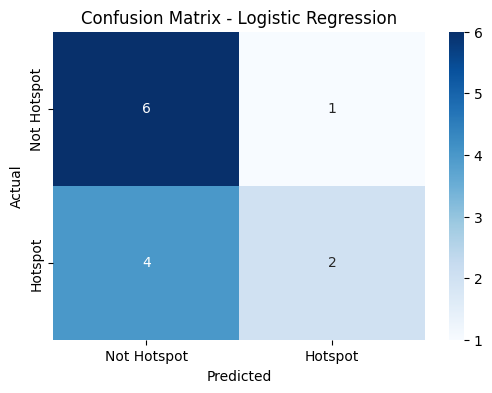

In [ ]:
# --- 4. Train Logistic Regression ---
print("\n--- 4. Training Logistic Regression ---")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# --- 5. Evaluate Logistic Regression ---
print("\n--- 6. Evaluating Logistic Regression ---")
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotspot', 'Hotspot'], yticklabels=['Not Hotspot', 'Hotspot'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- 5. Training Random Forest ---

--- 7. Evaluating Random Forest ---
Random Forest Accuracy: 0.7692
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.80      0.67      0.73         6

    accuracy                           0.77        13
   macro avg       0.78      0.76      0.76        13
weighted avg       0.77      0.77      0.77        13



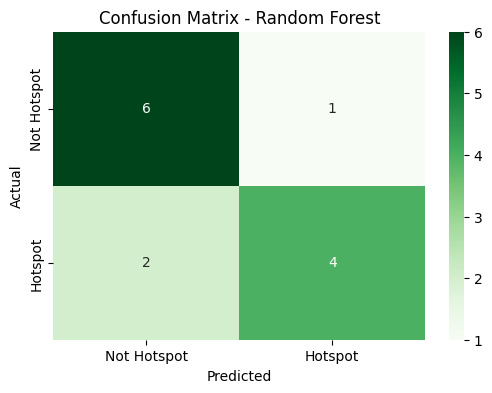

In [ ]:
# --- 6. Train Random Forest ---
print("\n--- 5. Training Random Forest ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# --- 7. Evaluate Random Forest ---
print("\n--- 7. Evaluating Random Forest ---")
y_pred_rf = rf_clf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Hotspot', 'Hotspot'], yticklabels=['Not Hotspot', 'Hotspot'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- 8. Feature Importance (Random Forest) ---
                     Feature  Importance
38   SO2_Seasonal_Avg_Spring    0.077558
15            SO2_<lambda_0>    0.075474
14         SO2_Annual_StdDev    0.071290
12           SO2_Annual_Mean    0.066531
39   SO2_Seasonal_Avg_Summer    0.060559
42    CO_Seasonal_Avg_Spring    0.057013
37     SO2_Seasonal_Avg_Fall    0.041536
16            CO_Annual_Mean    0.027378
24   CO_Days_Above_Threshold    0.026331
35   NO2_Seasonal_Avg_Summer    0.025817
28  PM25_Seasonal_Avg_Winter    0.024433
4             O3_Annual_Mean    0.023283
23  SO2_Days_Above_Threshold    0.021703
40   SO2_Seasonal_Avg_Winter    0.021231
29      O3_Seasonal_Avg_Fall    0.021101


<ipython-input-11-23480f7d80c4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


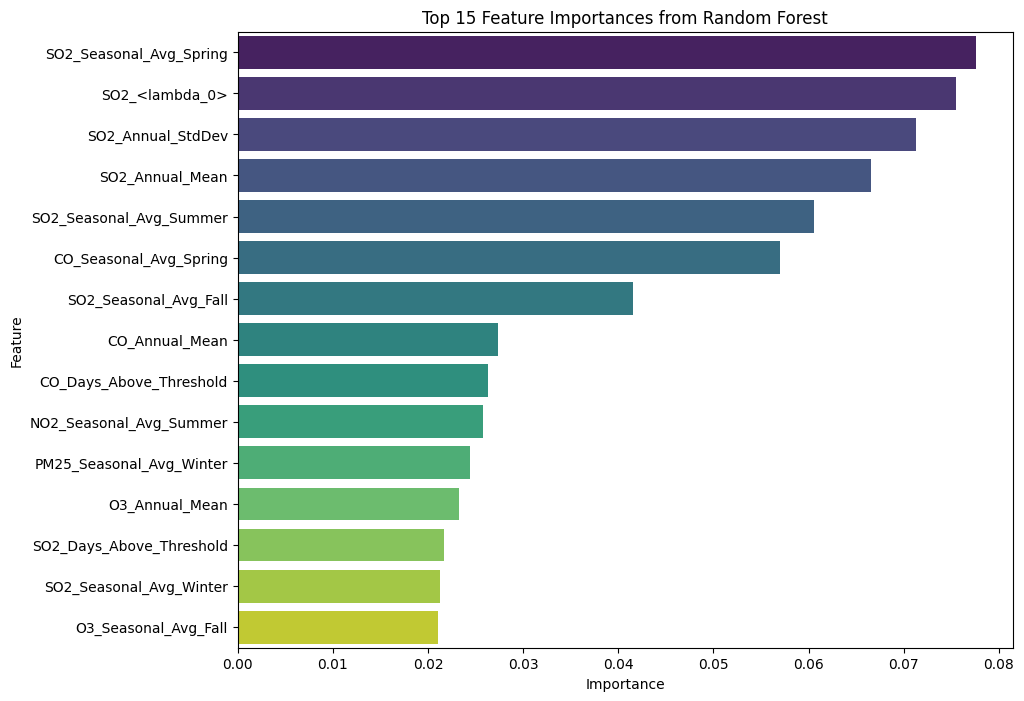

In [ ]:
# --- 8. Feature Importance (Random Forest) ---
print("\n--- 8. Feature Importance (Random Forest) ---")
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(15)) # Print top 15 features

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances from Random Forest')
plt.show()